In [1]:
# Libraries

import numpy
import os
import shutil
import sys

In [2]:
# Root directory

ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Code

from src.data.feature import annodata as data_anndata
from src.data.feature import target   as data_target
from src.io           import loader   as data_loader
from src.io           import writer   as data_writer

# 1. Setup

In [4]:
# Setup some directory paths

CWD = ROOT
OUT = os.path.join(CWD, 'out')
RES = os.path.join(CWD, 'res')

OUT_DATA  = os.path.join(OUT,      'nbp05-target')
OUT_PLOT  = os.path.join(OUT_DATA, 'plot')
RES_PLANT = os.path.join(RES,      'plant')
RES_NBP02 = os.path.join(OUT,      'nbp02-anndata')

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA, exist_ok = True)
os.makedirs(OUT_PLOT, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f'   Output Directory : {OUT_PLOT}')
print(f' Resource Directory : {RES_PLANT}')
print(f' Resource Directory : {RES_NBP02}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\out\nbp05-target
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\out\nbp05-target\plot
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\res\plant
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\out\nbp02-anndata


In [5]:
# Load the annotated and cleaned data

anndata = data_loader.load_h5ad(
	filename = os.path.join(RES_NBP02, 'arabidopsis-r36.h5ad')
)

# 2. Regression

In [6]:
# Extract the transcript tpm values

values, order = data_target.extract_tpm_multi(
	data      = anndata,
	layer     = 'boxcox1p',
	groups    = ['Tissue', 'Age', 'Group', 'Perturbation'],
	functions = [
		('max',  lambda x : numpy.max(x, axis = 0)),
		('p80',  lambda x : numpy.percentile(x, 80, axis = 0)),
		('mean', lambda x : numpy.mean(x, axis = 0)),
		('std',  lambda x : numpy.std(x, axis = 0))
	]
)

In [7]:
# Display an example of the transcript tpm values

gene = anndata.var.index.to_list()[0]

for index, (key, value) in enumerate(values[gene].items()) :
	print(f'{key:17s} : [{len(value):2d}] ' + ' '.join('{:5.3f}'.format(x) for x in value))

tissue-max        : [ 5] 2.302 2.858 2.989 2.711 2.908
tissue-p80        : [ 5] 1.792 1.725 2.488 1.684 2.065
tissue-mean       : [ 5] 1.568 1.301 2.219 1.464 1.716
tissue-std        : [ 5] 0.262 0.516 0.411 0.409 0.419
age-max           : [ 4] 2.881 2.858 1.880 2.989
age-p80           : [ 4] 2.008 2.180 1.624 2.356
age-mean          : [ 4] 1.521 1.697 1.400 1.921
age-std           : [ 4] 0.551 0.469 0.237 0.455
group-max         : [15] 2.302 2.790 2.873 1.596 2.881 1.671 2.858 2.279 1.808 1.880 1.790 2.064 2.989 2.711 2.908
group-p80         : [15] 1.874 1.658 2.500 1.480 2.000 1.559 2.246 2.182 1.698 1.624 1.773 1.776 2.493 2.340 2.195
group-mean        : [15] 1.593 1.261 2.249 1.237 1.676 1.463 1.793 1.729 1.328 1.400 1.749 1.653 2.228 1.968 1.792
group-std         : [15] 0.287 0.501 0.428 0.307 0.403 0.103 0.482 0.465 0.335 0.237 0.041 0.182 0.360 0.442 0.432
perturbation-max  : [ 7] 2.989 2.860 2.587 2.881 2.646 2.660 2.728
perturbation-p80  : [ 7] 2.350 2.085 2.214 2.074 1.836 1.

## 2.1 Distributions

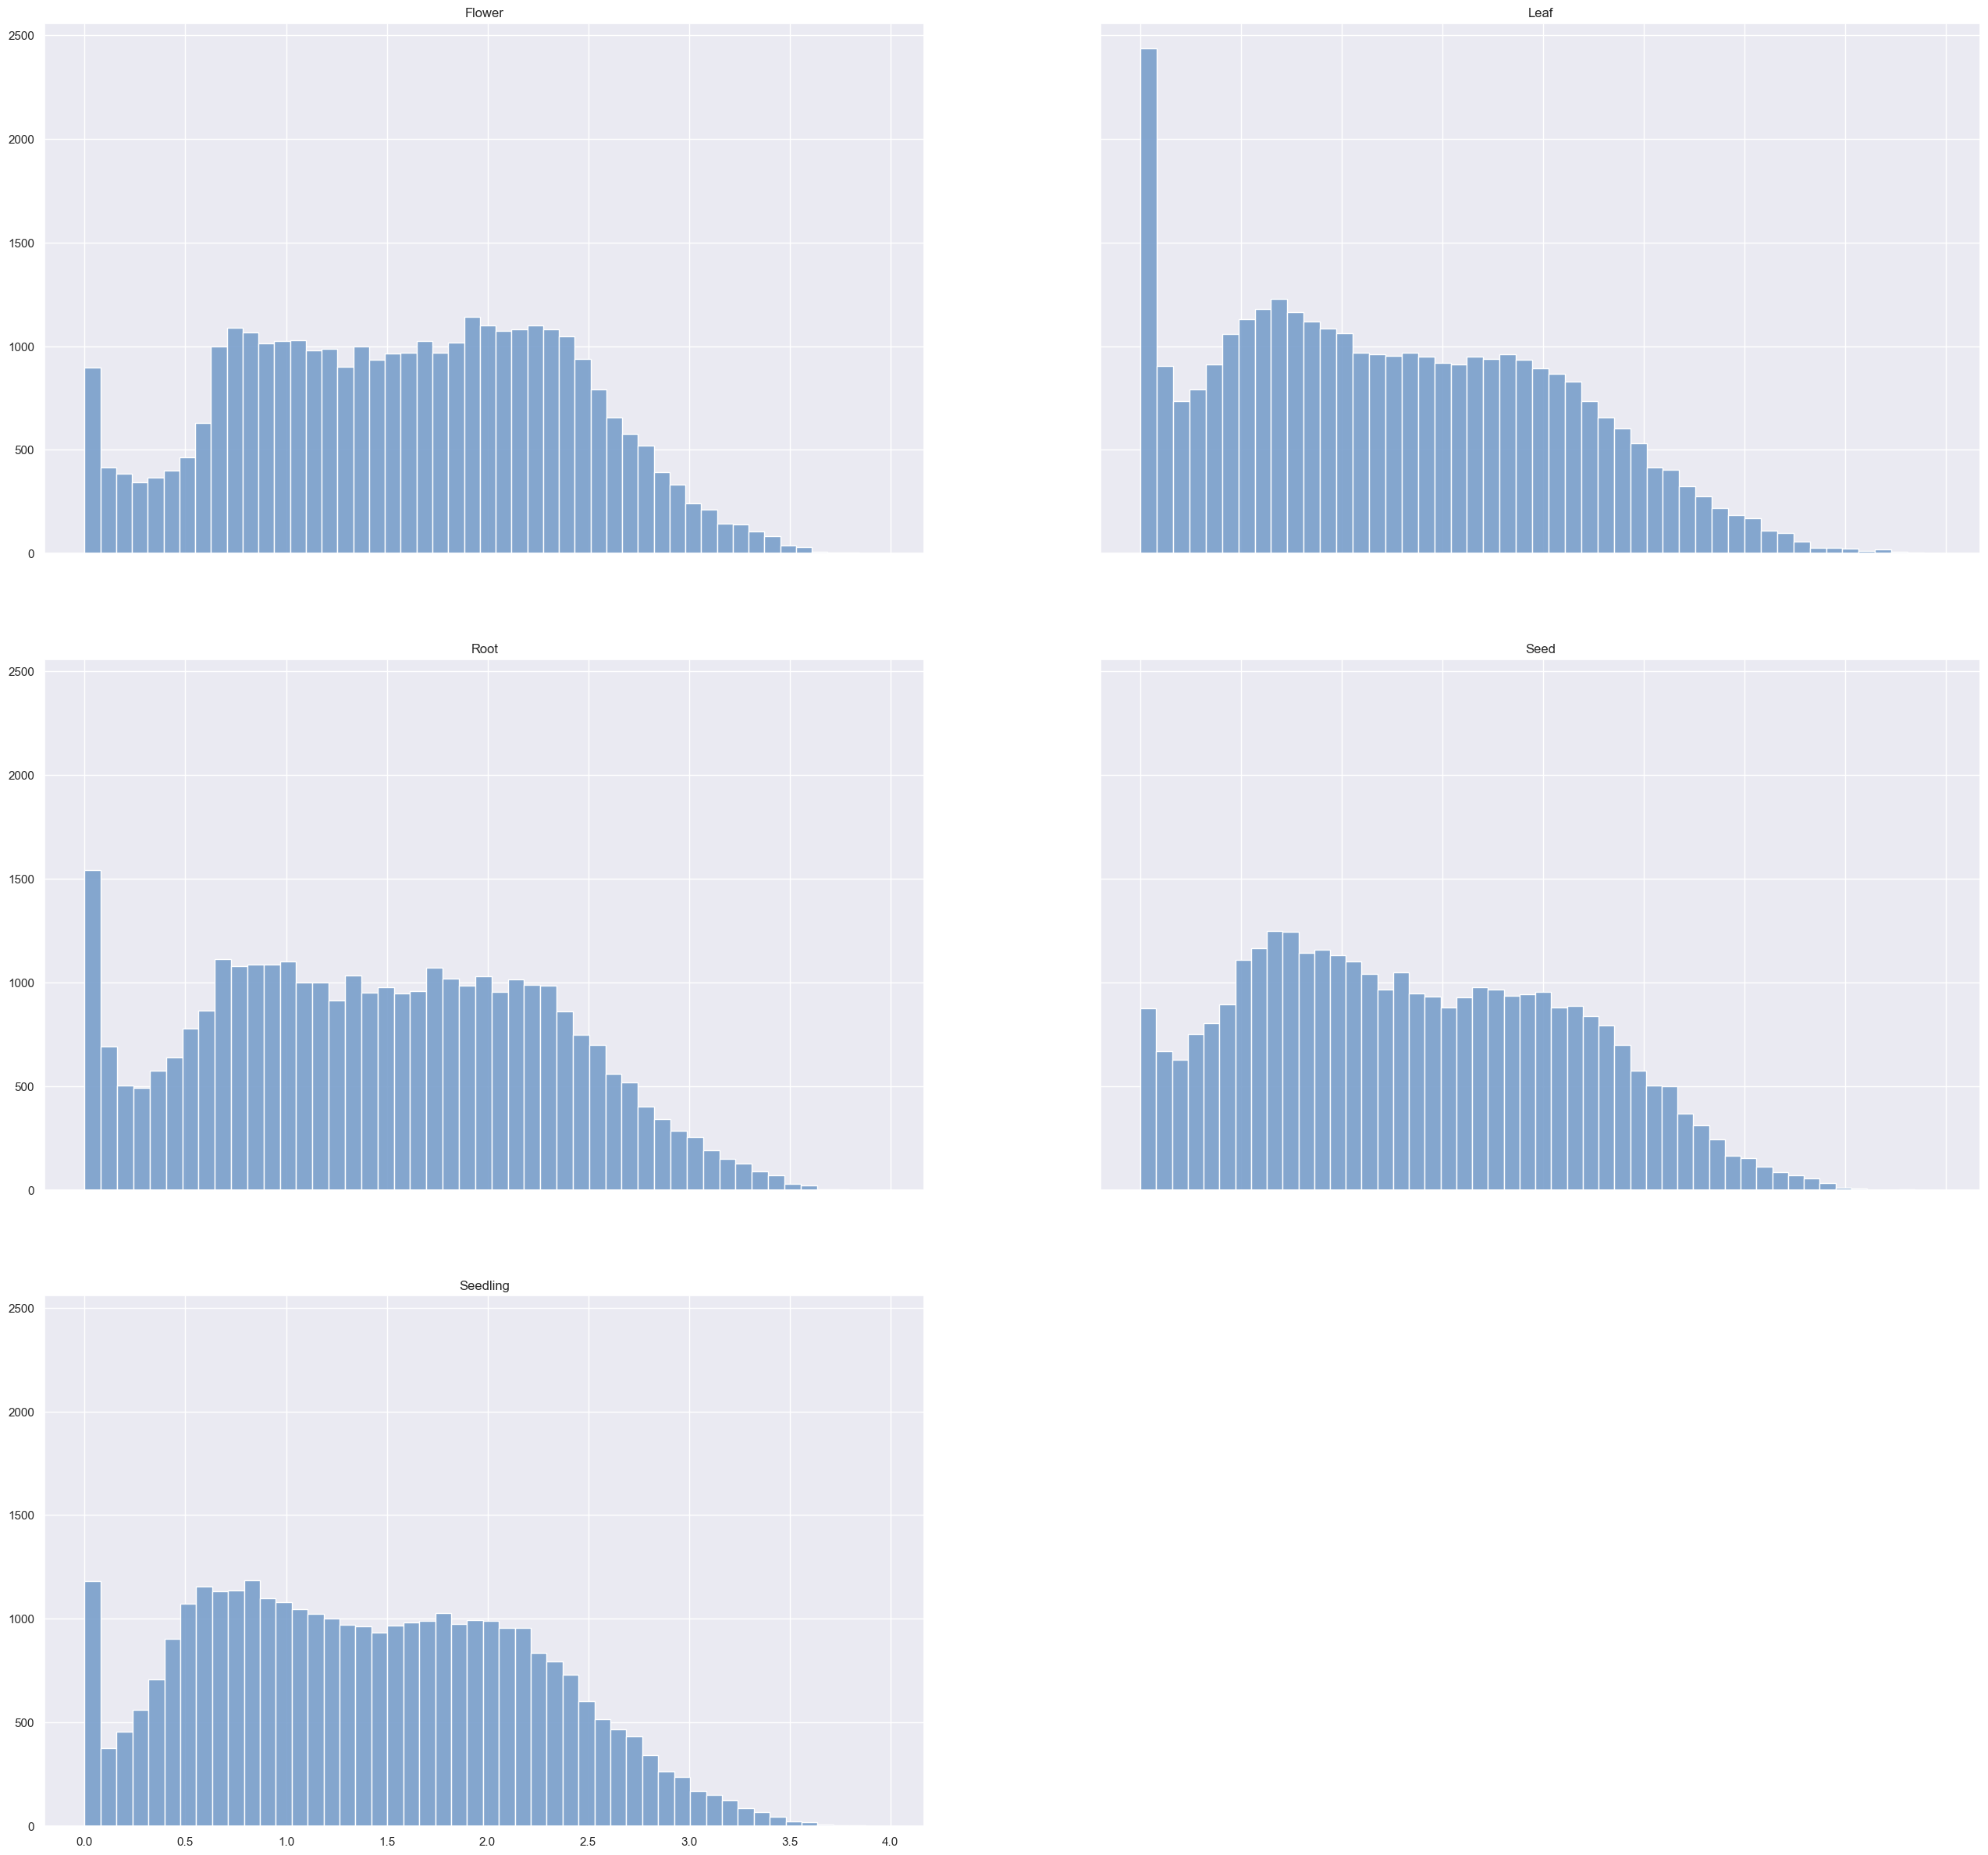

In [8]:
# Compute the regression distribution and display per tissue

distribution = data_target.distribution_group(
	data   = values,
	order  = order,
	select = 'mean',
	genes  = anndata.var.index.to_list()
)

data_target.distribution_histplot(
	data     = distribution,
	groupby  = 'tissue',
	discrete = False,
	filename = os.path.join(OUT_PLOT, 'distribution-tissue-mean')
)

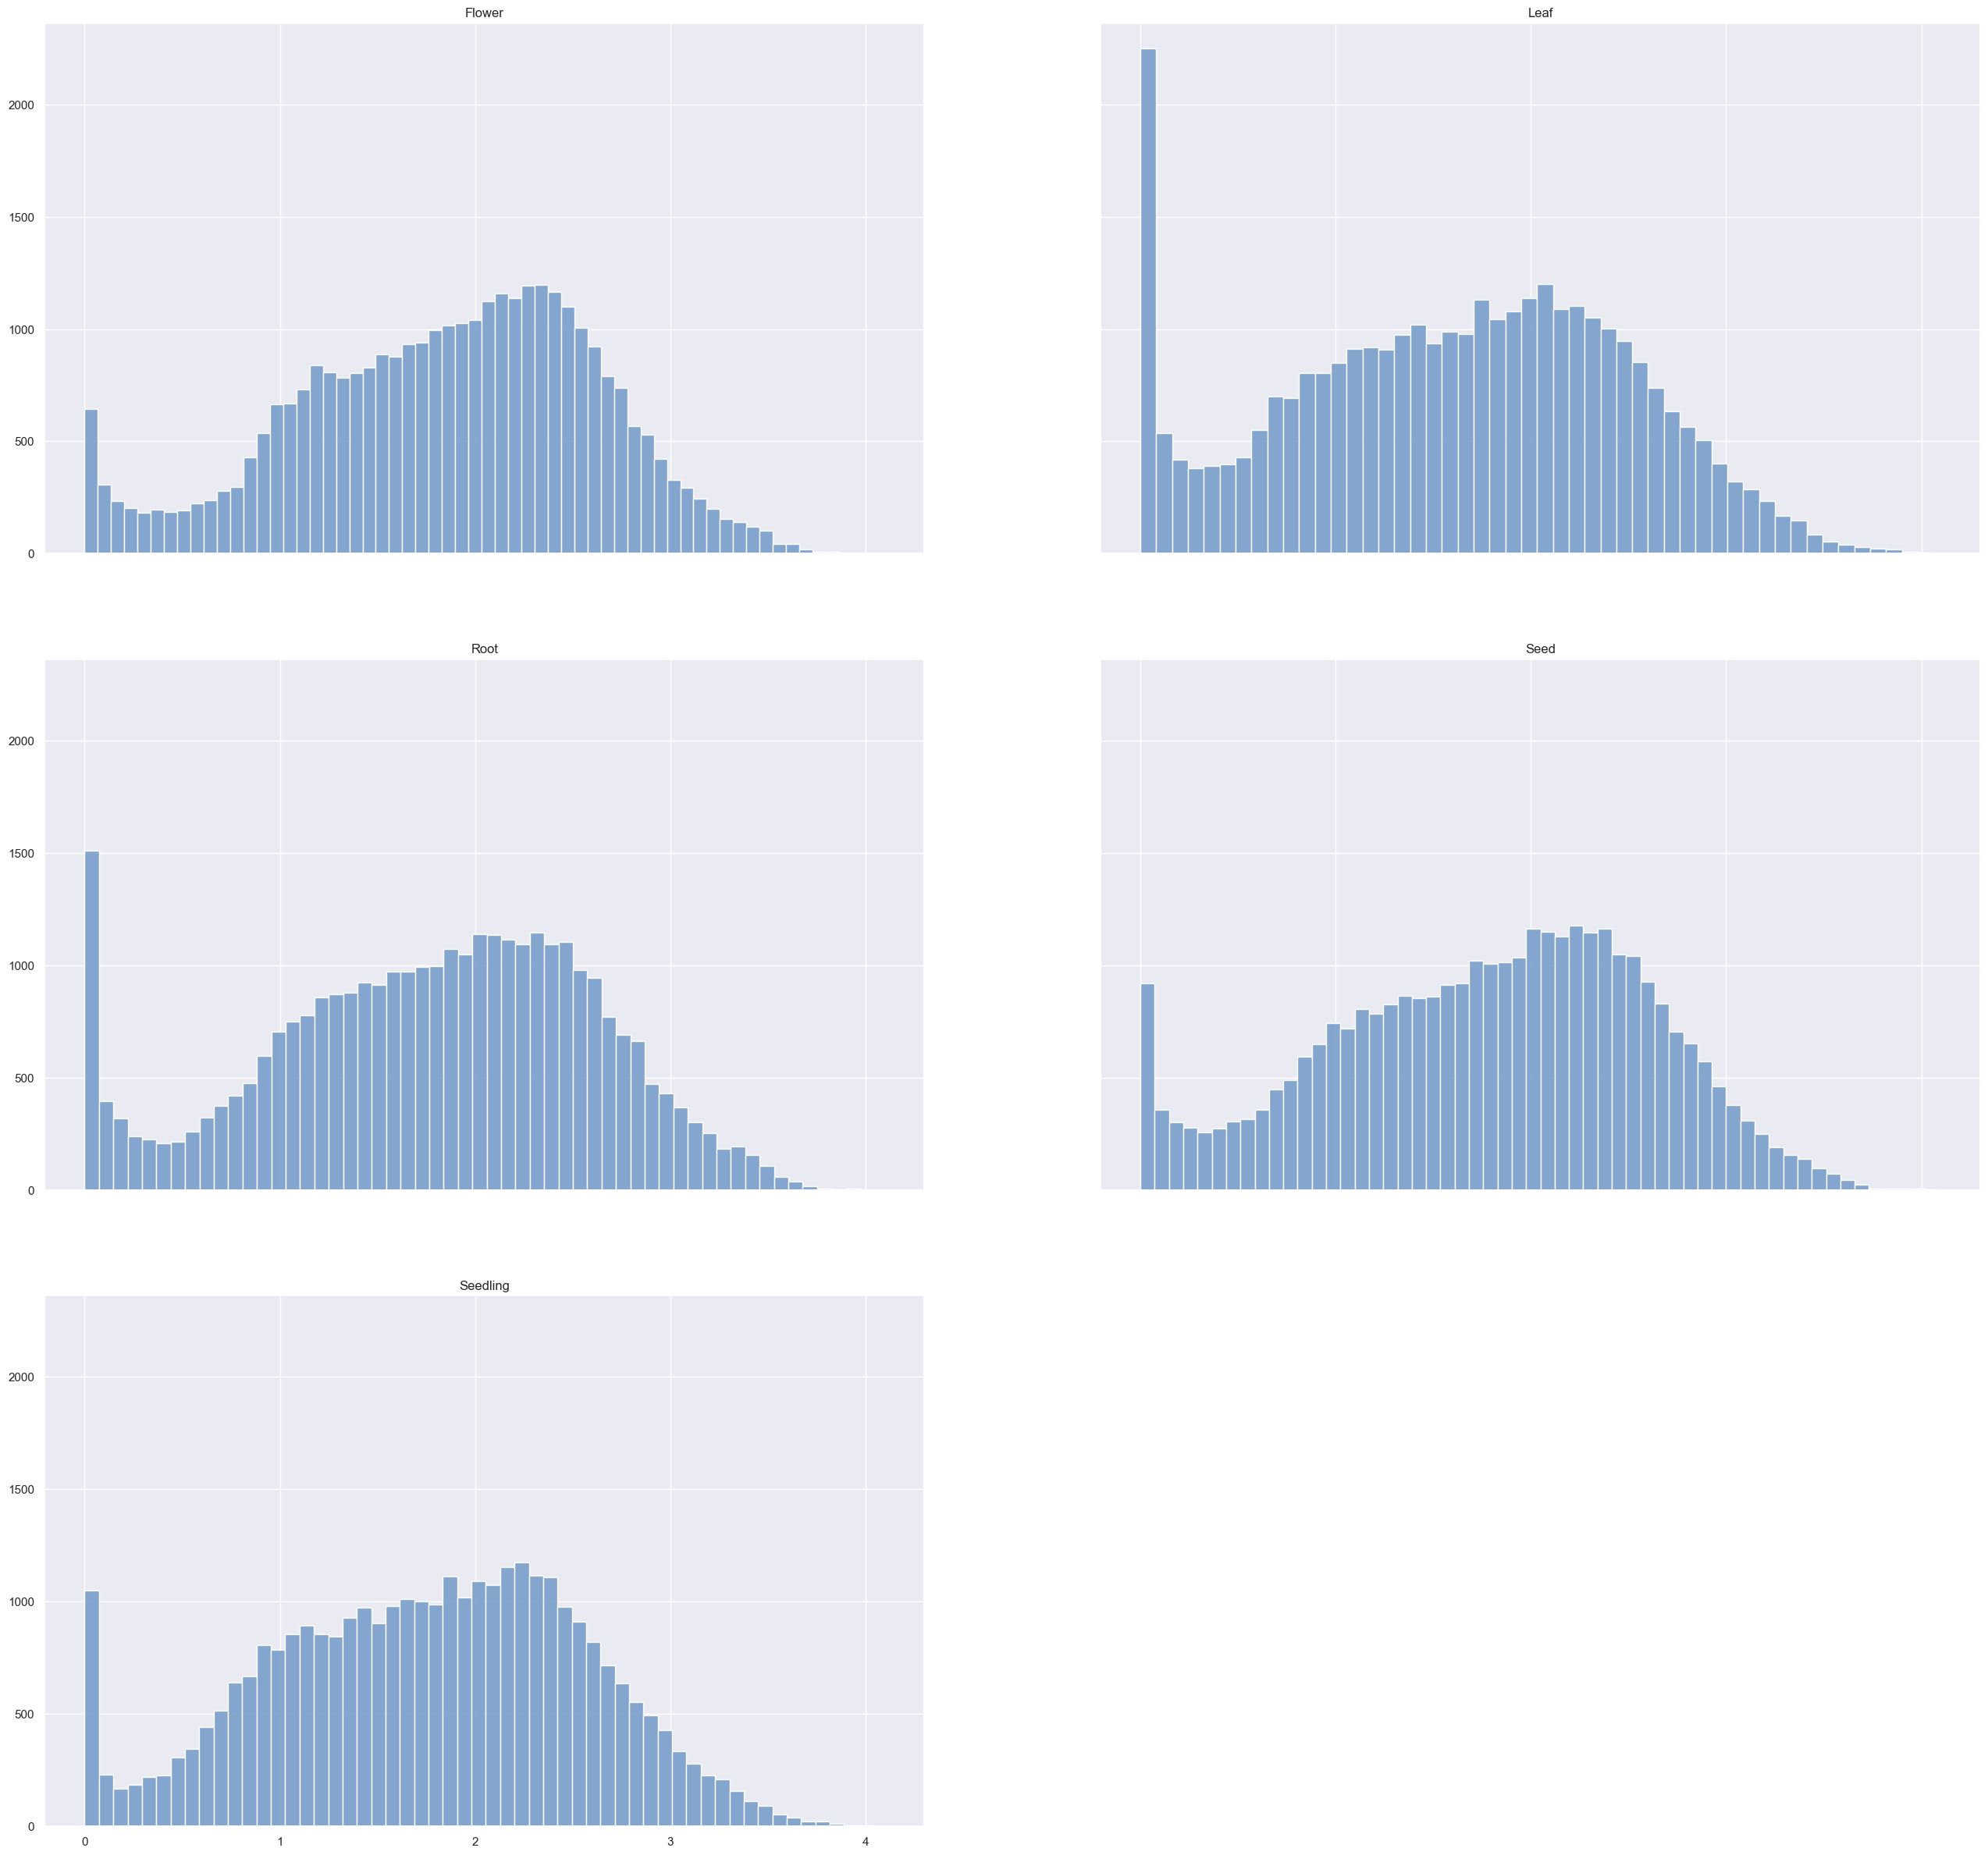

In [9]:
# Compute the regression distribution and display per tissue

distribution = data_target.distribution_group(
	data   = values,
	order  = order,
	select = 'p80',
	genes  = anndata.var.index.to_list()
)

data_target.distribution_histplot(
	data     = distribution,
	groupby  = 'tissue',
	discrete = False,
	filename = os.path.join(OUT_PLOT, 'distribution-tissue-p80')
)

## 2.2 Save

In [10]:
# Save the target transcript tpm values

data_writer.write_json(
	data     = values,
	filename = os.path.join(OUT_DATA, 'target-values.json')
)

data_writer.write_json(
	data     = order,
	filename = os.path.join(OUT_DATA, 'target-order.json')
)

# 3. Classification

In [11]:
# Extract the transcript tpm classification per group (reuses tpm values from regression extraction)

labels, bounds = data_target.classify_tpm(
	data    = values,
	classes = 5
)

In [12]:
# Display bounds in different configurations (start, values and mapping are manually set based on nbp02-anndata)

data_target.display_bounds_mapping(
	bounds     = bounds['tissue-mean'],
	start      = 'boxcox1p',
	values = {
		'min_value'  :  0.0,
		'max_value'  :  4.27402122112829000,
		'box_lambda' : -0.22037471317117235,
		'log_base'   :  2
	},
	mapping = {
		'log1p'    : None,
		'boxcox1p' : None,
		'normal'   : 'boxcox1p',
		'standard' : 'boxcox1p'
	}
)

                             boxcox1p |                           tpm
---------------------------------------------------------------------
level-0       0.00000 -       0.64098 |       0.00000 -       0.99577
level-1       0.64098 -       1.11283 |       0.99577 -       2.58483
level-2       1.11283 -       1.65357 |       2.58483 -       6.81833
level-3       1.65357 -       2.18456 |       6.81833 -      18.68308
level-4       2.18456 -       3.97095 |      18.68308 -  12,574.29814


In [13]:
# Display an example of the transcript classification

gene = anndata.var.index.to_list()[0]

for index, (key, value) in enumerate(labels[gene].items()) :
	print(f'{key:17s} : [{len(value):2d}] ' + ' '.join('{:1d}'.format(x) for x in value))

tissue-max        : [ 5] 2 3 4 3 3
tissue-p80        : [ 5] 2 2 4 2 3
tissue-mean       : [ 5] 2 2 4 2 3
age-max           : [ 4] 3 3 0 3
age-p80           : [ 4] 2 3 2 3
age-mean          : [ 4] 2 3 2 3
group-max         : [15] 2 3 4 1 4 1 4 2 1 1 1 2 4 3 4
group-p80         : [15] 2 2 4 1 2 2 3 3 2 2 2 2 4 3 3
group-mean        : [15] 2 2 4 2 2 2 3 3 2 2 3 2 3 3 3
perturbation-max  : [ 7] 3 3 2 3 2 3 3
perturbation-p80  : [ 7] 3 3 3 3 2 2 3
perturbation-mean : [ 7] 3 2 3 3 2 2 2


## 3.1 Distributions

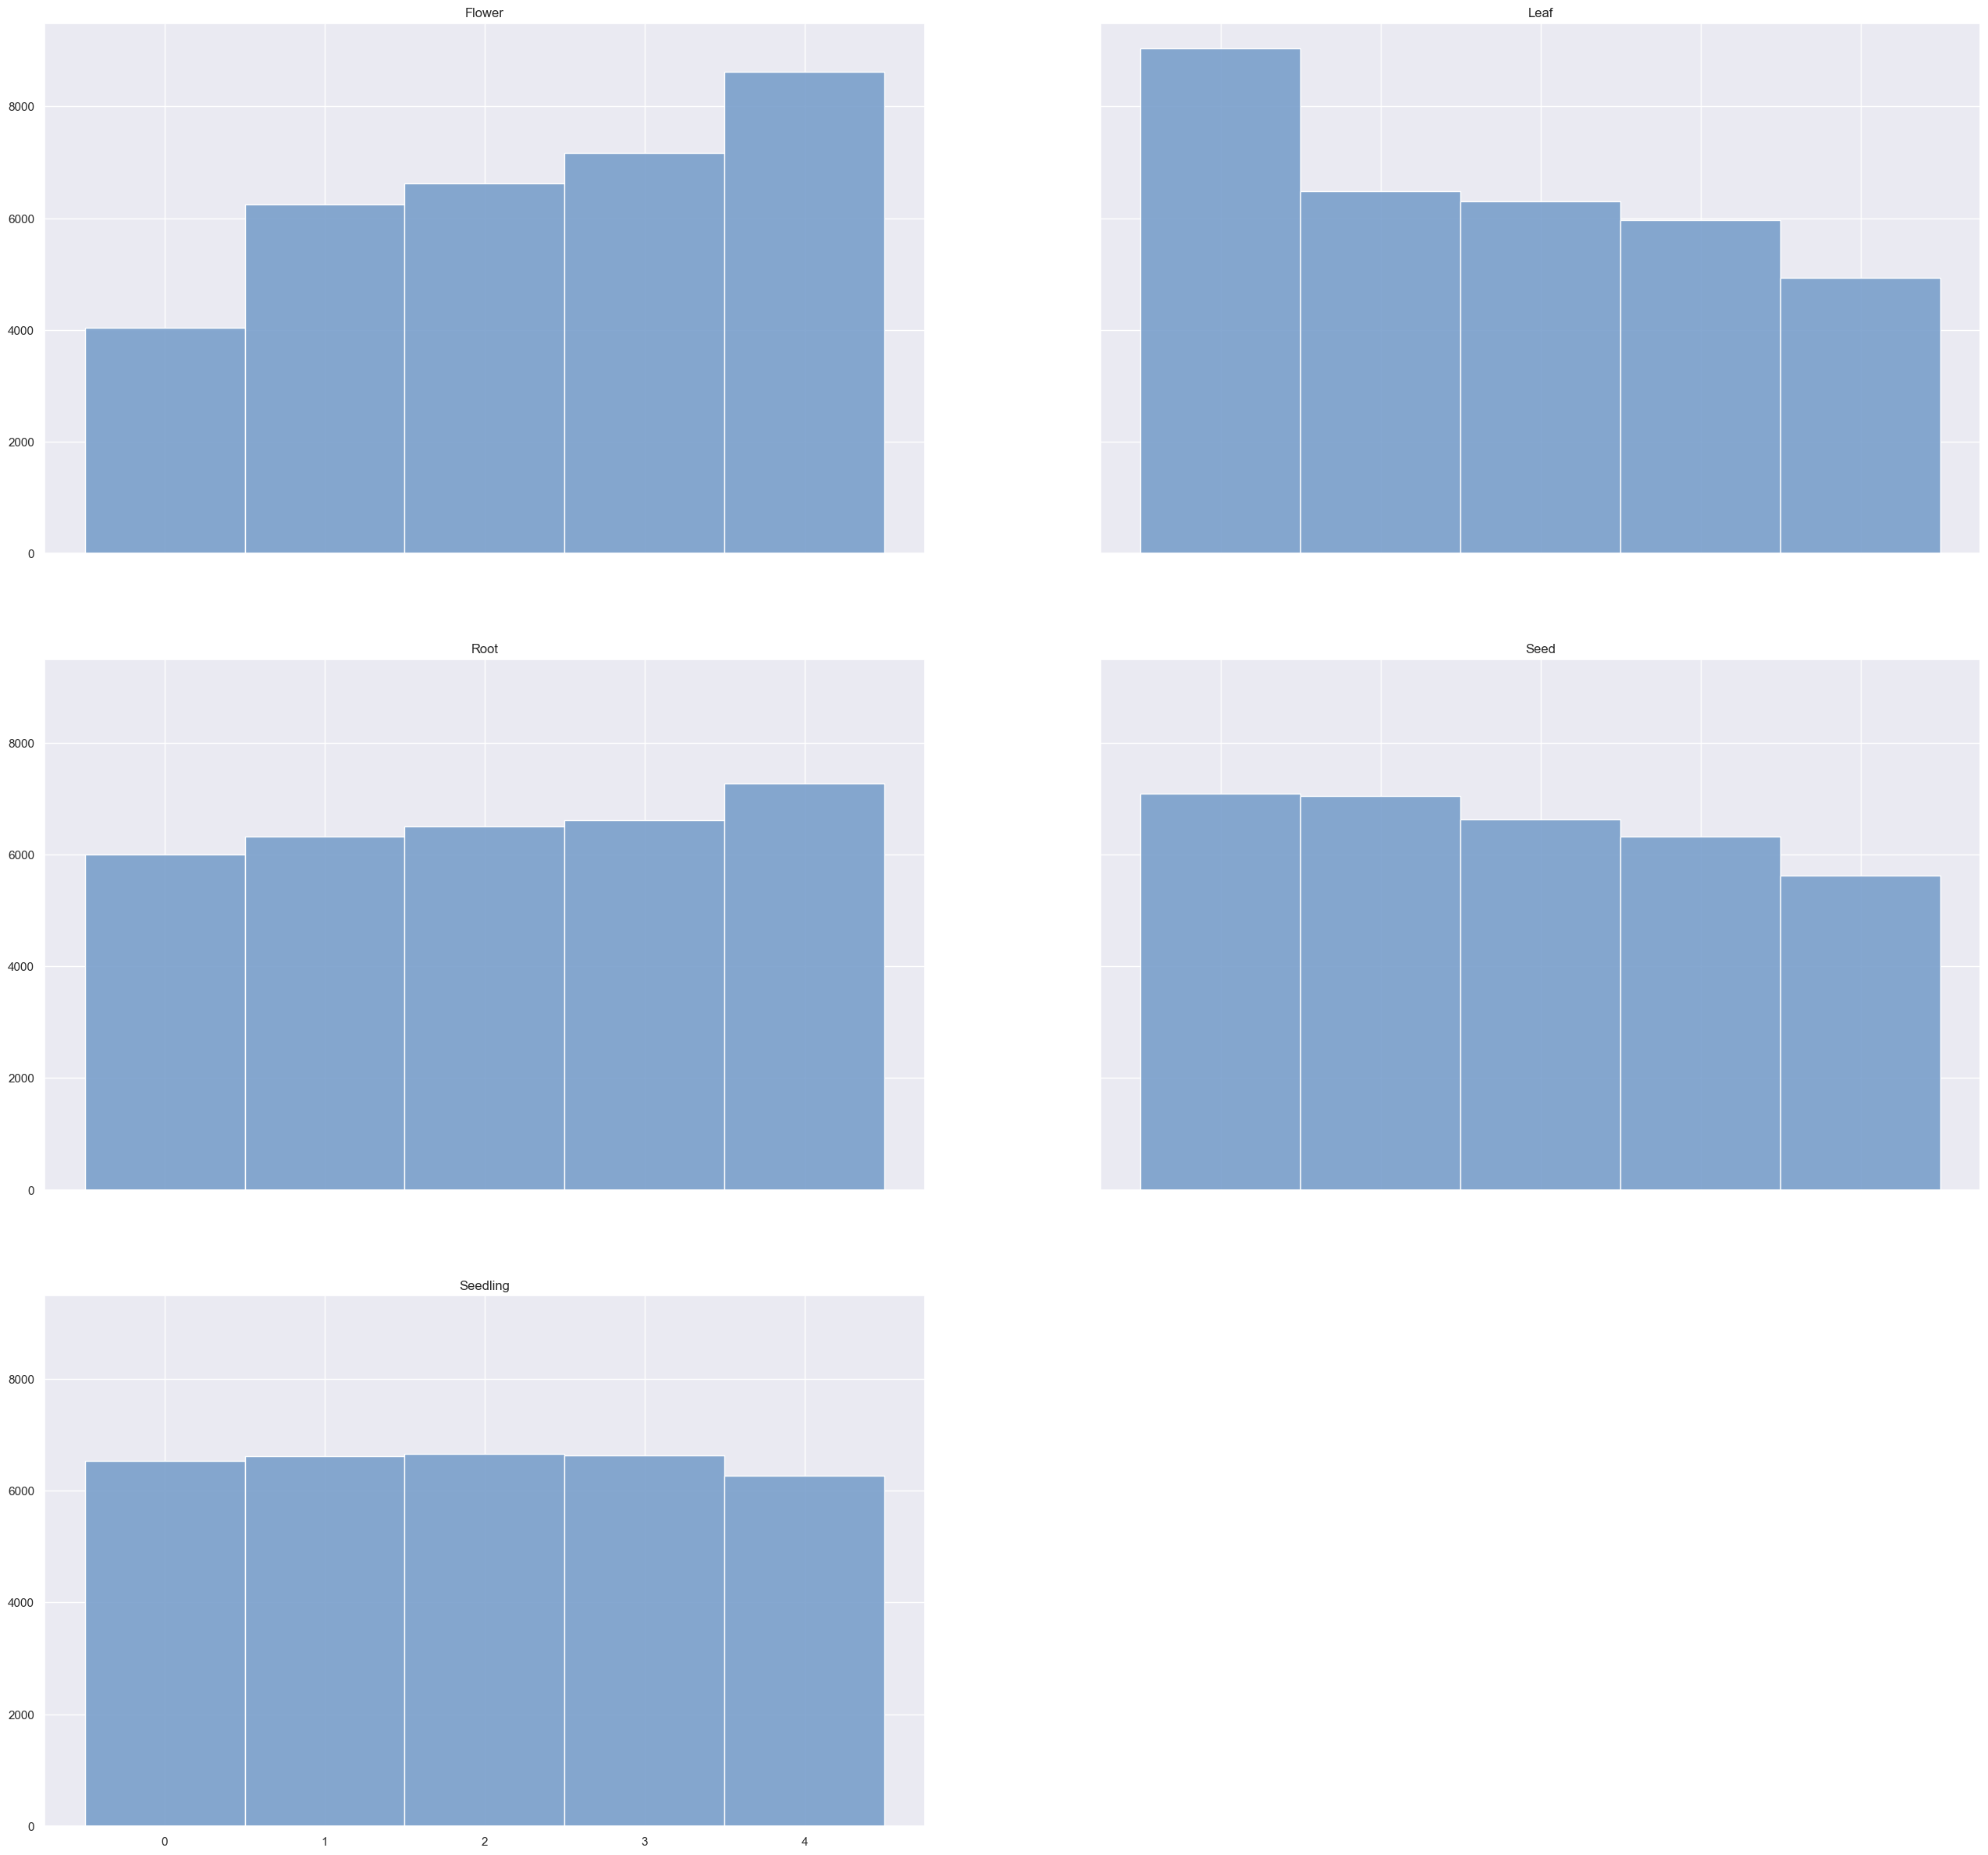

In [14]:
# Compute the classification distribution and display per tissue

distribution = data_target.distribution_group(
	data   = labels,
	order  = order,
	select = 'mean',
	genes  = anndata.var.index.to_list()
)

data_target.distribution_histplot(
	data     = distribution,
	groupby  = 'tissue',
	discrete = True,
	filename = os.path.join(OUT_PLOT, 'distribution-class-tissue-mean')
)

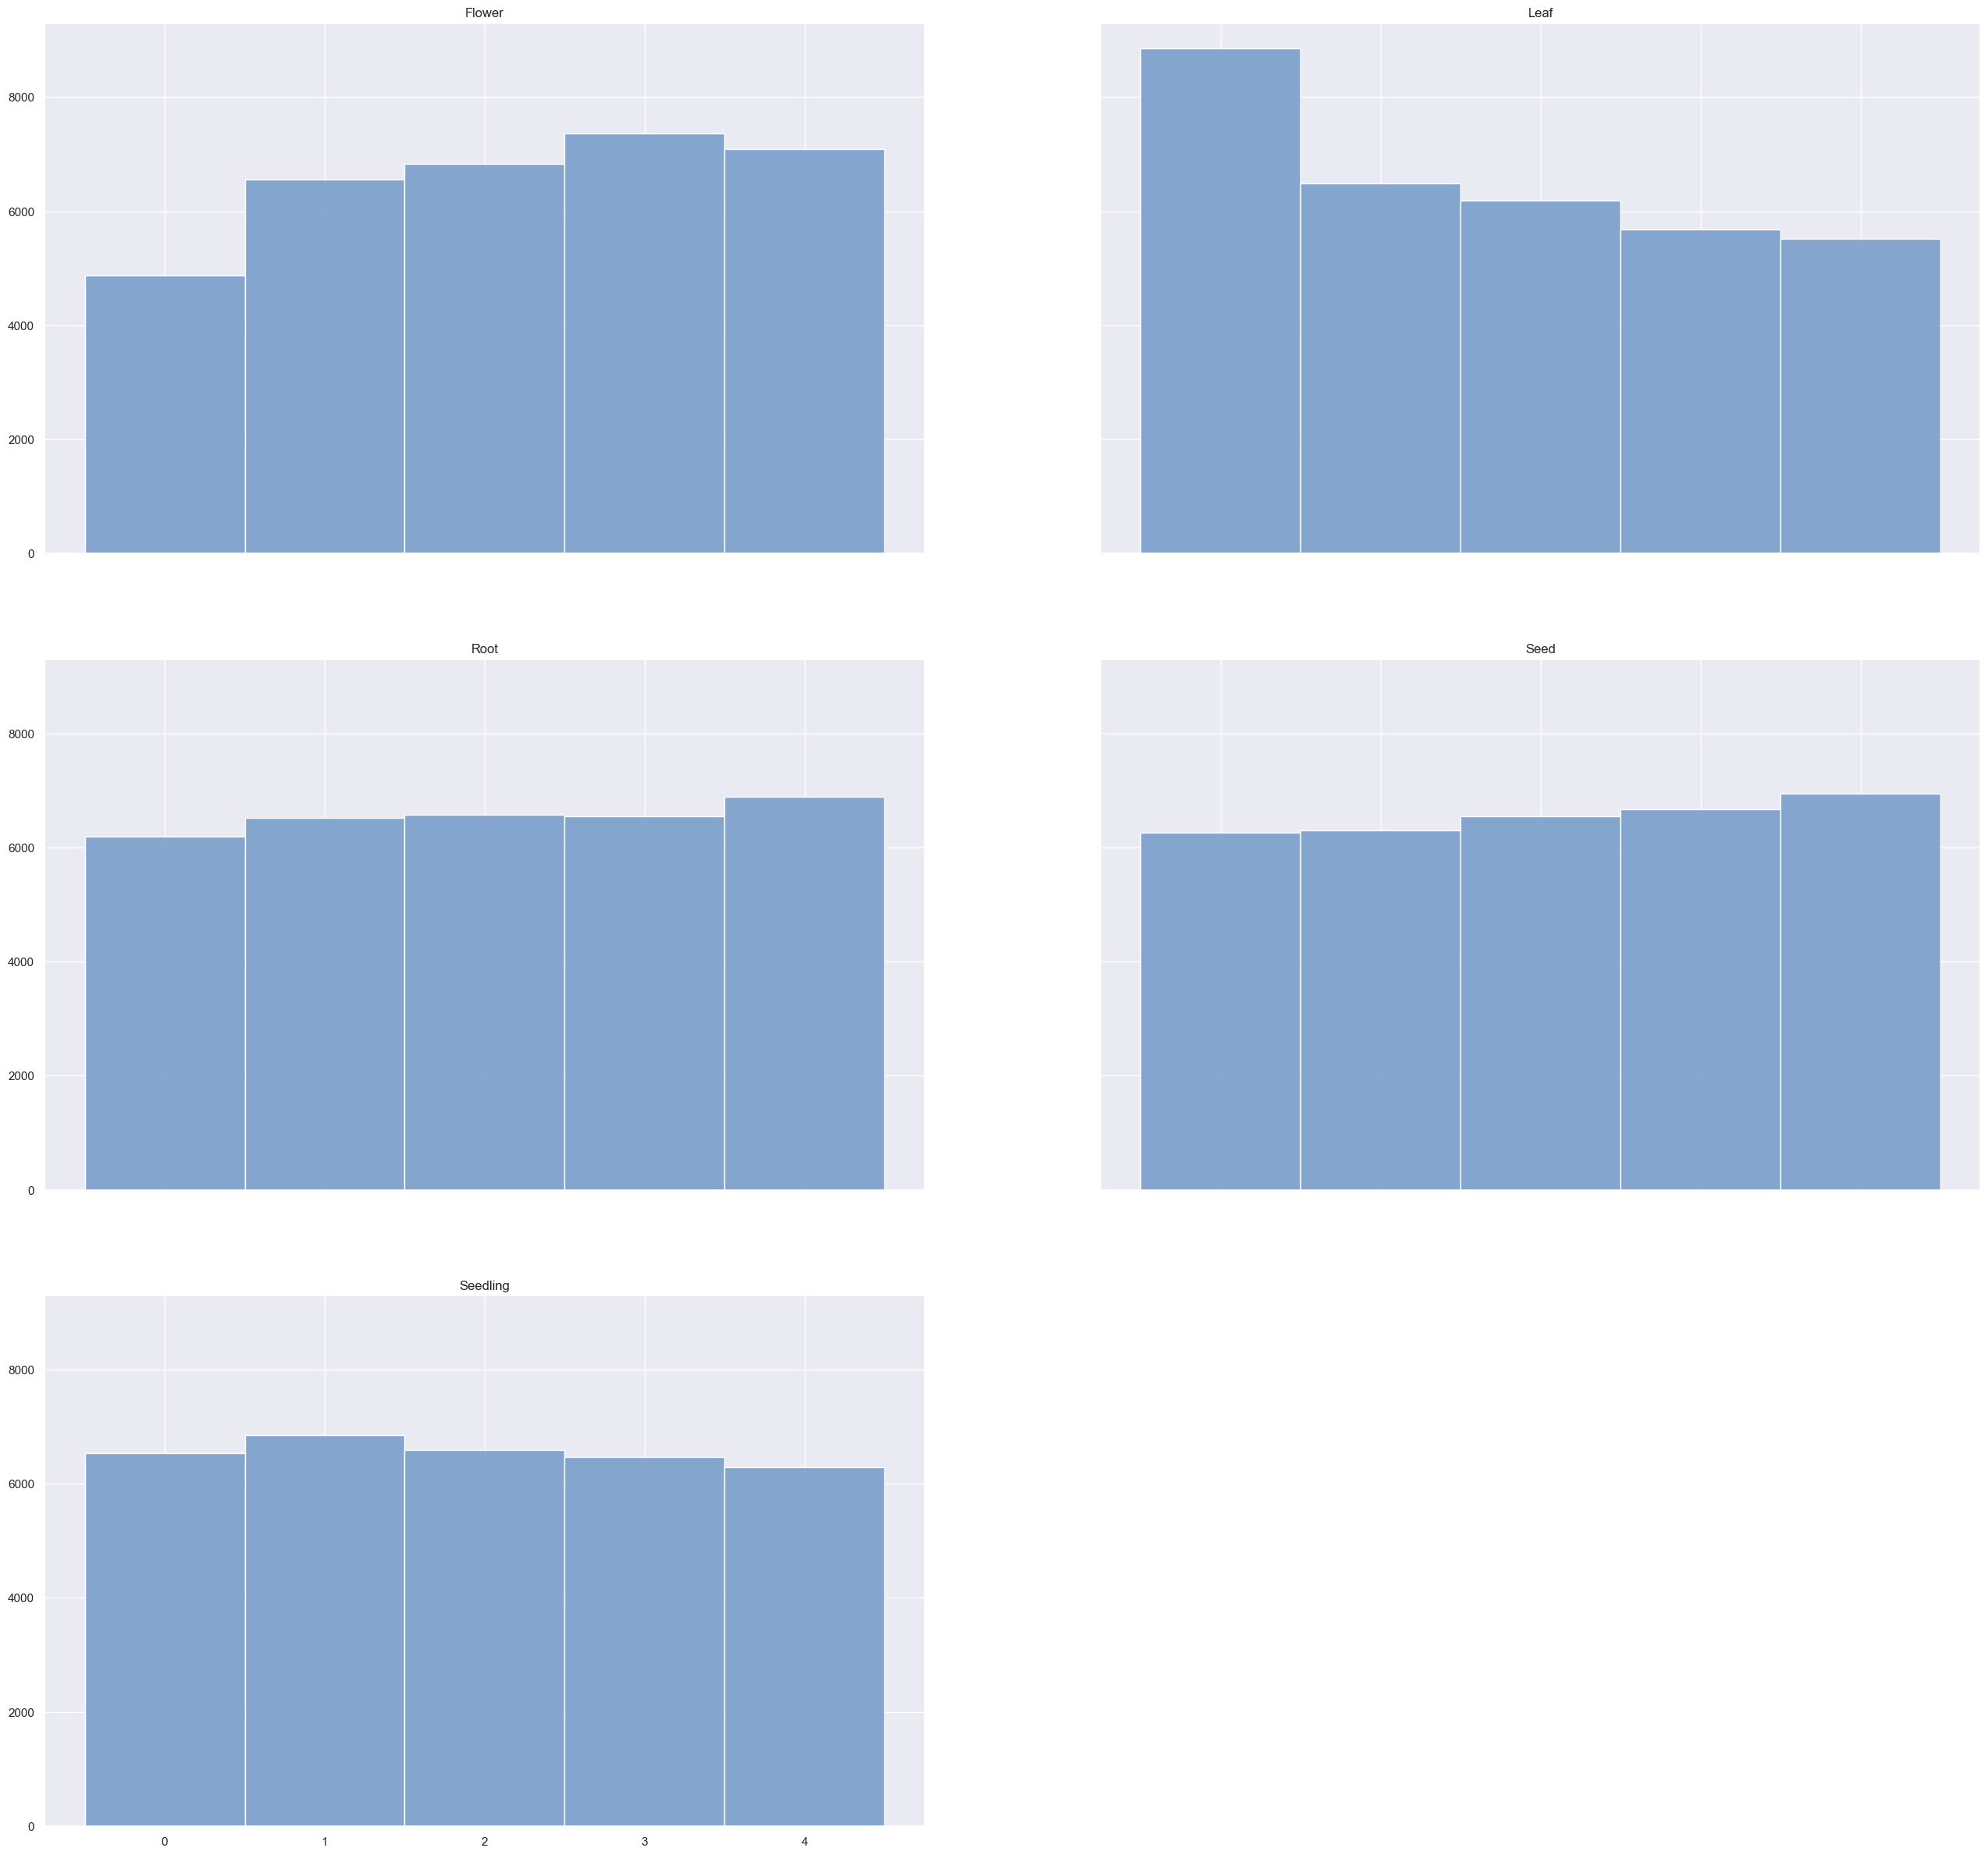

In [15]:
# Compute the classification distribution and display per tissue

distribution = data_target.distribution_group(
	data   = labels,
	order  = order,
	select = 'p80',
	genes  = anndata.var.index.to_list()
)

data_target.distribution_histplot(
	data     = distribution,
	groupby  = 'tissue',
	discrete = True,
	filename = os.path.join(OUT_PLOT, 'distribution-class-tissue-p80')
)

## 3.2 Save

In [16]:
# Save the target transcript classification

data_writer.write_json(
	data     = labels,
	filename = os.path.join(OUT_DATA, 'target-labels.json')
)